# DSCI552: HW4

## Part I: Lasso and Boosting Regression 

***Name: Cheng Peng***


***USC ID: 6898-9638-37***

In [14]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sn 
import matplotlib.pyplot as plt
import math
from xgboost import XGBRegressor

# a): Download the data 

In [7]:
#url = "/content/drive/My Drive/DSCI552/Homework 4 Data/data/communities.csv"
url="../data/communities.csv"
df = pd.read_csv(url, header=None)
# drop columns 0-4 that are not prodictive 
df.drop([0,1,2,3,4], axis = 1, inplace = True)
# replace ? with nan
df.replace("?", np.nan, inplace = True)

FileNotFoundError: [Errno 2] File b'/content/drive/My Drive/DSCI552/Homework 4 Data/data/communities.csv' does not exist: b'/content/drive/My Drive/DSCI552/Homework 4 Data/data/communities.csv'

In [4]:
df

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.00,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.00,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.00,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.00,0.19,0.30,0.73,0.64,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.00,0.11,0.72,0.64,0.61,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,0.03,1.0,0.42,0.74,0.14,0.64,0.30,0.06,0.46,0.41,0.49,0.50,0.27,0.00,0.16,0.36,0.52,0.01,0.16,0.08,0.11,0.65,0.12,0.71,0.17,0.68,0.14,0.70,0.39,0.41,...,0.39,0.41,0.41,0.50,0.48,0.39,0.00,0.00,0.22,0.28,0.34,0.48,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,0.06,1.0,0.28,0.76,0.10,0.30,0.26,0.37,0.48,0.24,0.18,0.20,0.26,0.18,0.20,0.23,0.26,0.04,0.32,0.33,0.37,0.22,0.24,0.77,0.10,0.41,0.22,0.24,0.42,0.75,...,0.54,0.61,0.54,0.69,0.67,0.31,0.01,0.00,0.53,0.25,0.17,0.10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,0.17,1.0,0.31,0.47,0.17,0.45,0.58,0.48,0.57,0.35,0.31,0.34,0.25,0.19,0.28,0.22,0.28,0.12,0.31,0.52,0.58,0.21,0.50,0.46,0.63,0.40,0.54,0.32,0.50,0.53,...,0.34,0.39,0.37,0.52,0.58,0.53,0.06,0.02,0.25,0.68,0.61,0.79,0.76,0.06,0.3,0.93,0.36,0.04,0.17,0.19,0.3,0.97,0.7,0.15,0.34,0,0.34,0.1,0.36,0.25,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,0.09,1.0,0.44,0.64,0.21,0.55,0.42,0.24,0.45,0.47,0.40,0.40,0.29,0.20,0.31,0.27,0.37,0.03,0.16,0.30,0.35,0.42,0.37,0.57,0.44,0.57,0.27,0.48,0.32,0.87,...,0.62,0.75,0.64,0.43,0.44,0.40,0.04,0.01,0.45,0.64,0.54,0.59,0.52,0.02,0.25,0.97,0.3,0.01,0.1

In [5]:
df_train = df.iloc[:1495].copy()
df_test = df.iloc[1495:].copy()
print("The training set has {} samples, the test set has {} samples.".format(len(df_train), len(df_test)))

The training set has 1495 samples, the test set has 499 samples.


# b): Data Imputation 

In [6]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
imputer.fit(df_train)


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [7]:
df_train = imputer.transform(df_train)
df_test = imputer.transform(df_test)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [8]:
df_train.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.030000,0.130000,0.960000,0.170000,0.060000,0.180000,0.440000,0.130000,0.940000,0.930000,0.030000,0.070000,0.100000,0.070000,0.020000,0.57000,0.290000,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.00,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.00,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.00,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.90,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
5,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,0.04,1.00,0.52,0.68,0.20,0.61,0.28,0.15,0.25,0.62,0.72,0.76,0.77,0.28,0.52,0.48,0.60,0.01,0.12,0.13,0.12,0.80,0.10,0.65,0.19,0.77,0.06,0.91,0.49,0.57,...,0.63,0.68,0.62,0.47,0.59,0.11,0.00,0.0,0.70,0.42,0.49,0.73,0.64,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.58,0.10,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.14
6,0.01,0.39,0.00,0.98,0.06,0.02,0.30,0.37,0.23,0.60,0.02,0.81,0.42,0.50,0.23,0.68,0.61,0.21,0.54,0.43,0.47,0.44,0.40,0.24,0.86,0.24,0.36,0.01,0.11,0.29,0.41,0.36,0.28,0.54,0.44,0.53,0.33,0.49,0.25,0.34,...,0.35,0.42,0.35,0.46,0.44,0.31,0.00,0.0,0.15,0.81,0.77,0.91,0.84,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.05,0.08,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
7,0.01,0.74,0.03,0.46,0.20,1.00,0.52,0.55,0.36,0.35,0.00,0.00,0.16,0.44,1.00,0.23,0.53,0.97,0.41,0.15,0.10,0.12,0.08,0.17,0.27,0.18,0.21,0.03,0.64,0.96,0.82,0.12,1.00,0.26,0.43,0.34,0.71,0.18,0.38,0.47,...,0.24,0.25,0.24,0.64,0.59,0.28,0.00,0.0,0.59,0.58,0.52,0.79,0.78,0.074728,0.214854,0.919205,0

In [9]:
df_test.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,0.02,1.0,0.73,0.48,0.31,0.85,0.37,0.12,0.49,0.83,1.00,1.00,0.72,0.48,0.41,0.11,0.96,0.00,0.07,0.04,0.03,0.98,0.11,0.65,0.11,0.73,0.04,0.99,0.75,0.43,...,0.87,1.00,0.85,0.83,0.82,0.29,0.00,0.00,0.33,0.45,0.57,0.56,0.74,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,0.02,1.0,0.40,0.87,0.37,0.52,0.14,0.07,0.81,0.36,0.28,0.28,0.33,0.33,0.25,0.25,0.31,0.00,0.14,0.12,0.11,0.33,0.24,0.74,0.11,0.39,0.20,0.48,0.48,0.26,...,0.34,0.36,0.36,0.21,0.41,0.94,0.00,0.00,0.17,0.45,0.52,0.59,0.57,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,0.00,0.0,0.08,0.42,0.78,0.35,0.61,0.75,0.41,0.08,0.11,0.14,0.13,0.17,0.13,0.15,0.17,0.03,0.94,0.64,0.67,0.33,0.65,0.28,0.11,0.84,0.36,0.39,0.43,0.67,...,0.12,0.11,0.09,0.62,0.32,0.39,0.00,0.00,0.19,0.47,0.37,0.38,0.49,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,0.06,1.0,0.47,0.72,0.14,0.52,0.44,0.19,0.62,0.45,0.35,0.34,0.40,0.43,0.34,0.27,0.49,0.01,0.10,0.15,0.29,0.22,0.25,0.66,0.48,0.35,0.44,0.31,0.39,0.37,...,0.55,0.55,0.54,0.41,0.52,0.44,0.00,0.00,0.10,0.62,0.70,0.75,0.64,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,0.04,1.0,0.58,0.91,0.16,0.47,0.10,0.14,0.30,0.55,0.46,0.48,0.34,0.55,0.32,0.36,0.50,0.01,0.09,0.21,0.26,0.41,0.15,0.84,0.12,0.28,0.28,0.52,0.50,0.42,...,0.58,0.62,0.62,0.44,0.71,0.50,0.00,0.00,0.22,0.33,0.16,0.06,0.27,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
5,0.01,0.48,0.02,0.77,0.84,0.05,0.37,0.26,0.20,0.50,0.02,1.0,1.00,0.59,0.56,0.94,0.41,0.07,0.58,1.00,1.00,1.00,1.00,1.00,1.00,0.73,0.72,0.00,0.04,0.06,0.04,1.00,0.17,0.47,0.32,0.64,0.01,1.00,0.11,0.24,...,1.00,1.00,1.00,0.09,0.63,0.07,0.00,0.00,0.49,0.35,0.79,0.85,0.76,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.01,0.23,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.04
6,0.05,0.64,0.03,0.84,0.21,0.33,0.45,0.50,0.30,0.24,0.00,0.0,0.39,0.60,0.27,0.30,0.37,0.60,0.45,0.36,0.26,0.25,0.31,0.21,0.26,0.35,0.35,0.04,0.25,0.32,0.43,0.14,0.44,0.51,0.43,0.26,0.56,0.26,0.59,0.34,...,0.43,0.49,0.43,0.44,0.71,0.28,0.00,0.00,0.21,0.63,0.32,0.44,0.76,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.55205,0.323598,0.02,0.39,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.25
7,0.27,0.37,0.22,0.67,0.42,0.07,0.39,0.50,0.33,0.42,0.28,1.0,0.23,0.43,0.15,0.41,0.47,0.55,0.61,0.26,0.24,0.27,0.23,0.12,0.16,0.24,0.28,0.26,0.44,0.23,0.35,0.24,0.46,0.40,0.35,0.45,0.45,0.34,0.76,0.48,...,0.28,0.31,0.27,0.59,0.44,0.43,0.23,0.04,0.23,0.47,0.45,0.63,0.58,0.040000,0.100000,0.950000,0

# c): Coreelation Matrix 

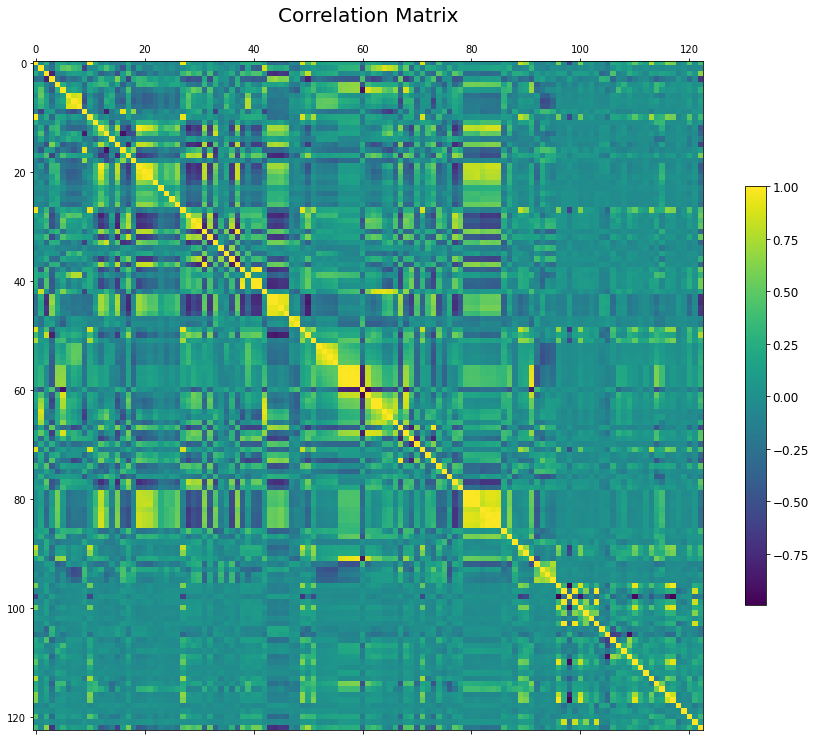

In [25]:
import seaborn as sn 
import matplotlib.pyplot as plt
corr_matrix = df_train.corr()
figure = plt.figure(figsize=(15,15))
plt.matshow(corr_matrix, fignum = figure.number)
colour_bar = plt.colorbar(shrink = 0.5)
colour_bar.ax.tick_params(labelsize = 12)
plt.title("Correlation Matrix", fontsize = 20)
plt.show()


d): Coefficient of Variation 

In [28]:
def CoefVar(x):
    return x.std()/x.mean()

coeff_var = df_train.agg(["std", "mean", CoefVar])
coeff_var.index = ["std", "mean", "cv"]

In [29]:
coeff_var

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122
std,0.130359,0.164284,0.256970,0.248594,0.208910,0.233694,0.155993,0.143352,0.167816,0.176903,0.131784,0.446024,0.212649,0.181887,0.203964,0.181128,0.171563,0.228419,0.165264,0.202688,0.195612,0.191443,0.174971,0.165765,0.200512,0.189723,0.187362,0.133167,0.232286,0.217857,0.206893,0.214574,0.206186,0.174160,0.205961,0.177862,0.204535,0.190687,0.184756,0.176036,...,0.211570,0.250375,0.215974,0.168040,0.186273,0.190693,0.102736,0.098665,0.232661,0.205550,0.179759,0.200681,0.195745,0.061436,0.062595,0.059094,0.060309,0.068649,0.066527,0.077818,0.062595,0.092010,0.089078,0.098904,0.080364,0.081740,0.092540,0.052208,0.079706,0.095167,0.105482,0.202085,0.230799,0.088122,0.059852,0.082528,0.164029,0.238201,0.062190,0.237699
mean,0.058167,0.461732,0.179839,0.752829,0.153712,0.144963,0.422649,0.492087,0.335425,0.428569,0.064649,0.693318,0.359217,0.553498,0.290589,0.495786,0.475619,0.323445,0.478441,0.374883,0.350508,0.368281,0.291940,0.202555,0.326107,0.281814,0.387057,0.056849,0.307880,0.320147,0.387619,0.362040,0.366602,0.495545,0.401070,0.441512,0.396094,0.440722,0.462622,0.435666,...,0.371973,0.421465,0.383311,0.489819,0.448308,0.405552,0.029599,0.022983,0.218281,0.611311,0.537365,0.629572,0.655906,0.074728,0.214854,0.919205,0.245272,0.100711,0.213975,0.344561,0.214854,0.682301,0.725314,0.224937,0.136234,0.101674,0.263013,0.077113,0.552050,0.323598,0.064107,0.233759,0.165197,0.163975,0.080502,0.713054,0.451883,0.093304,0.190753,0.240609
cv,2.241105,0.355800,1.428885,0.330213,1.359100,1.612091,0.369083,0.291315,0.500310,0.412776,2.038461,0.643318,0.591978,0.328614,0.701898,0.365335,0.360715,0.706206,0.345421,0.540670,0.558079,0.519828,0.599341,0.818368,0.614866,0.673222,0.484068,2.342443,0.754470,0.680490,0.533753,0.592680,0.562425,0.351450,0.513530,0.402849,0.516379,0.432670,0.399366,0.404062,...,0.568778,0.594059,0.563443,0.343065,0.415502,0.470207,3.470952,4.292923,1.065880,0.336245,0.334519,0.318758,0.298434,0.822130,0.291340,0.064288,0.245887,0.681643,0.310908,0.225847,0.291340,0.134853,0.122813,0.439697,0.589896,0.803948,0.351845,0.677028,0.144382,0.294089,1.645408,0.864499,1.397110,0.537409,0.743487,0.115739,0.362989,2.552946,0.326026,0.987909


# e): Scatter Plot 

In [31]:
import math
n = math.floor(math.sqrt(128))

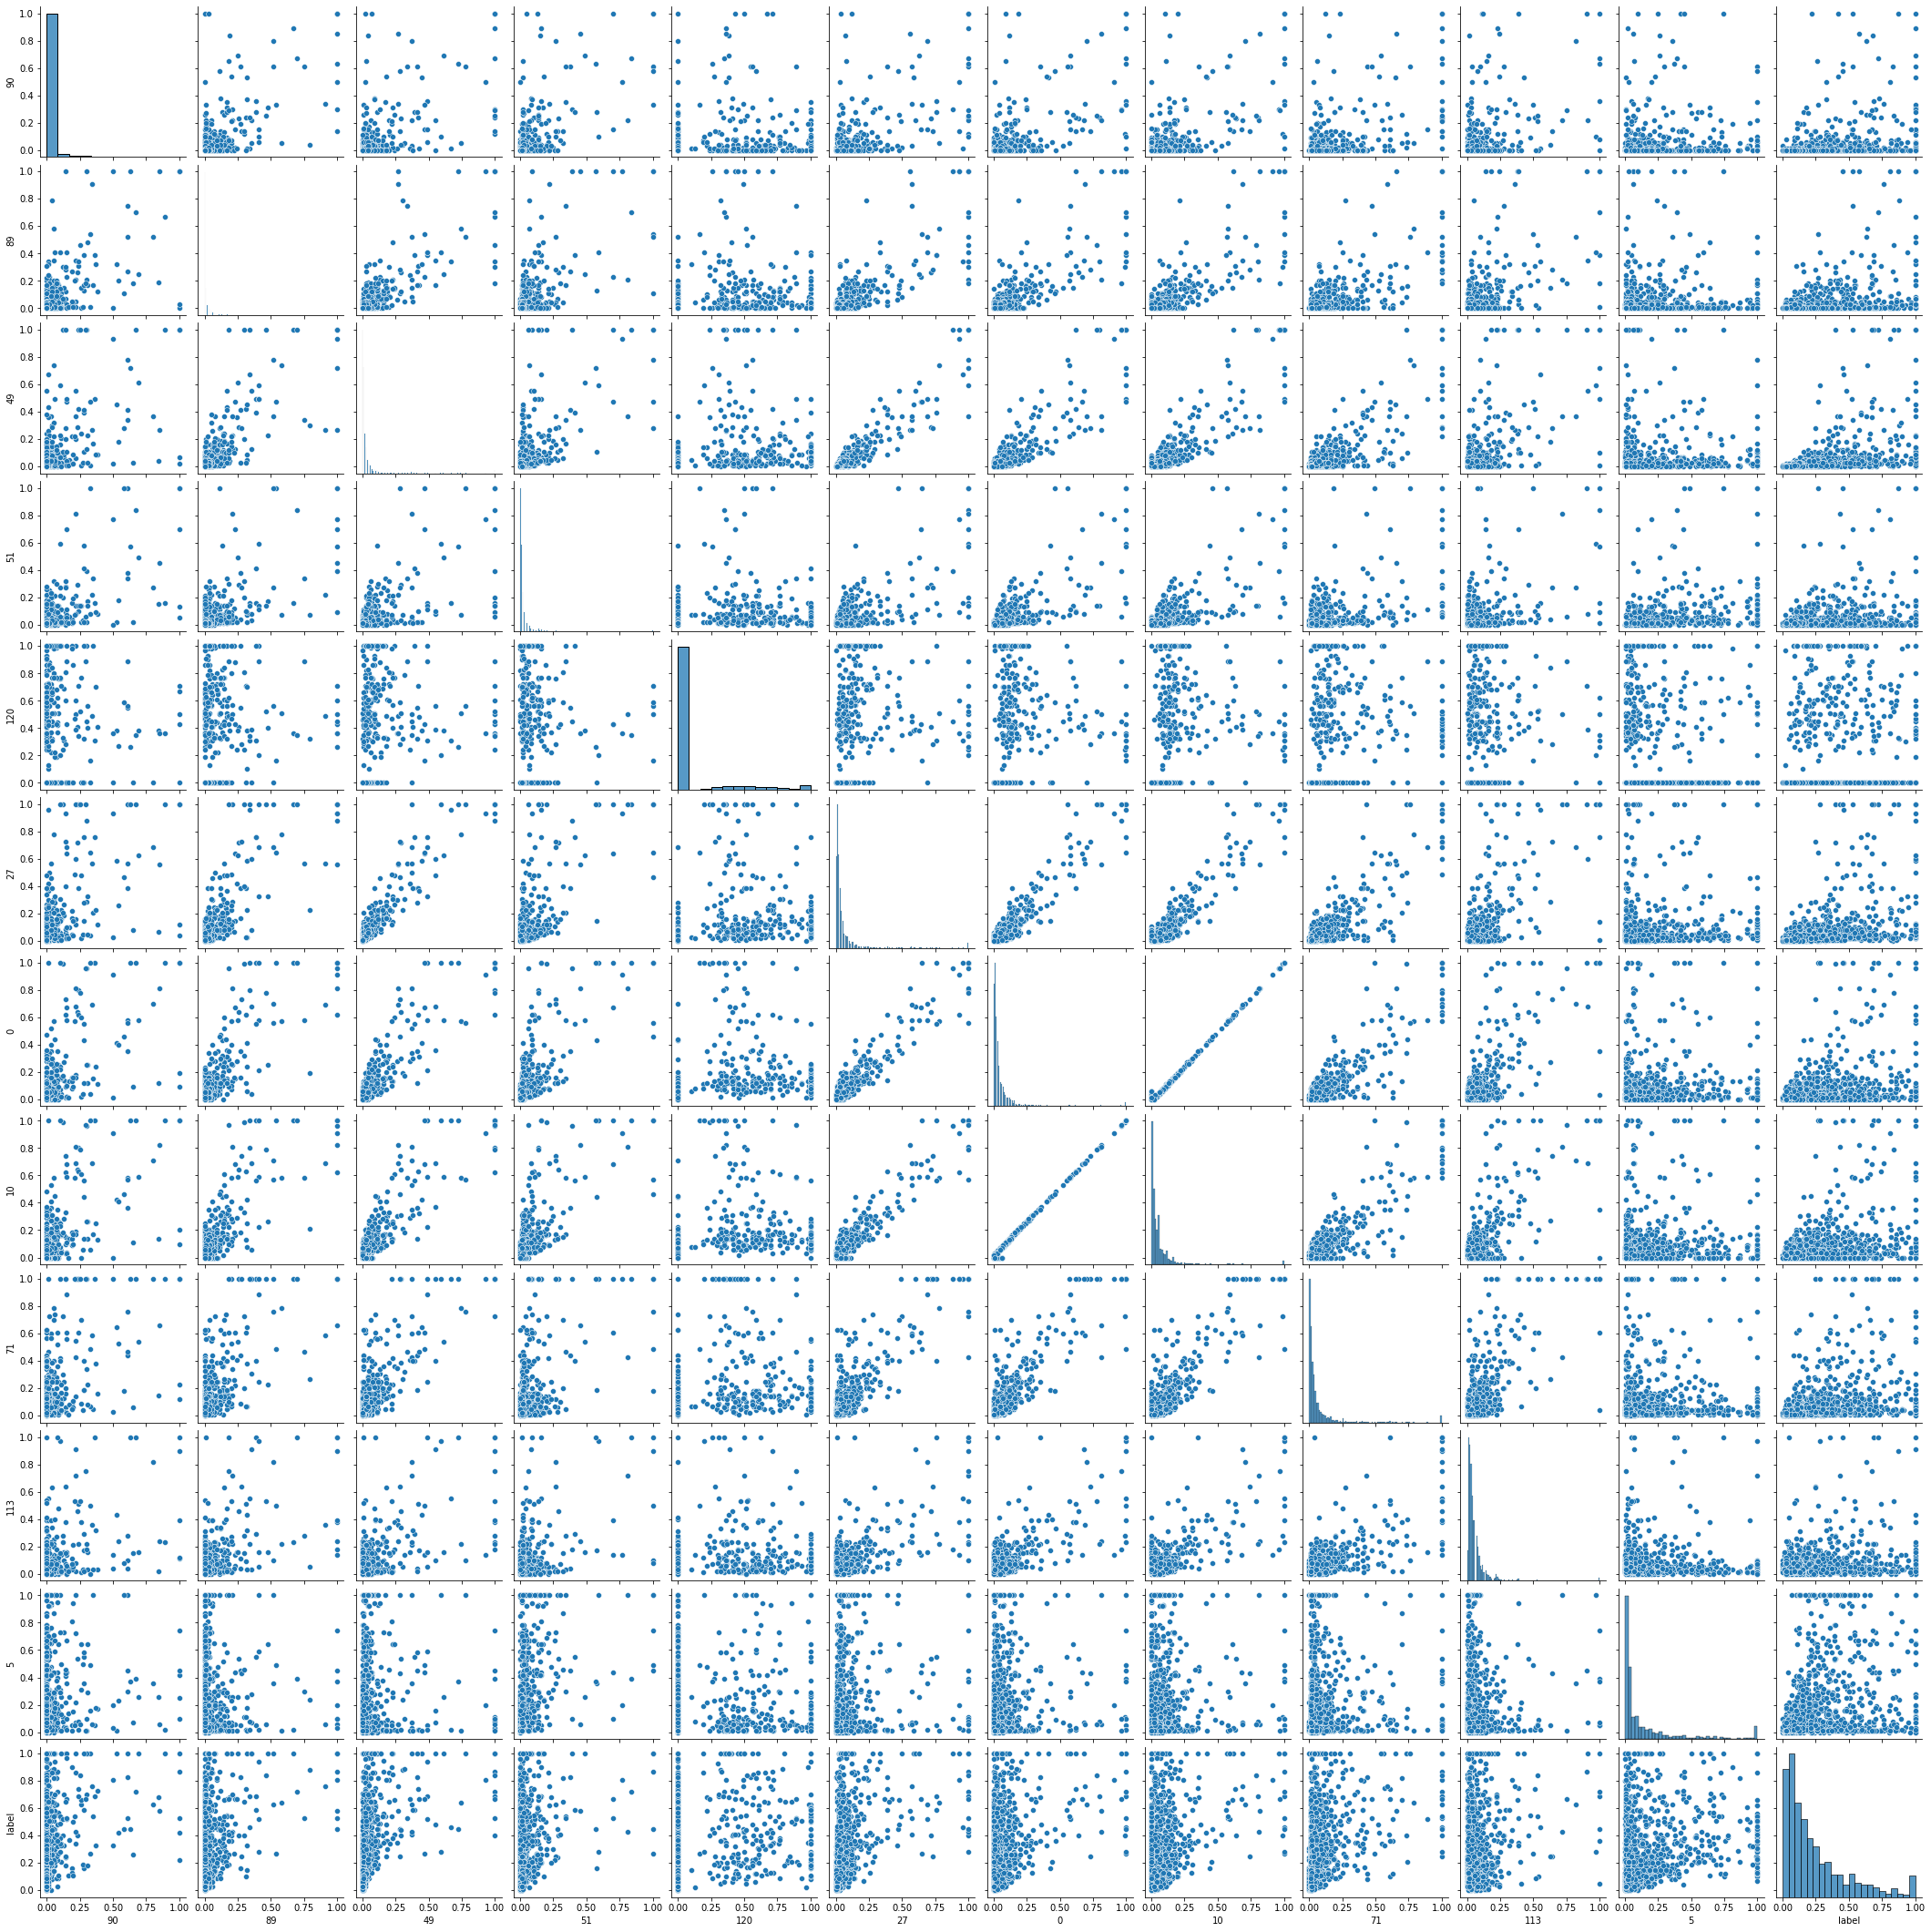

In [44]:
# find top n cv values 
import seaborn as sn 
top_n = coeff_var.iloc[2].nlargest(n).index
top_n = df_train.iloc[:,top_n].copy()
top_n["label"] = df_train.iloc[:,-1]
sn.pairplot(top_n)
plt.show()

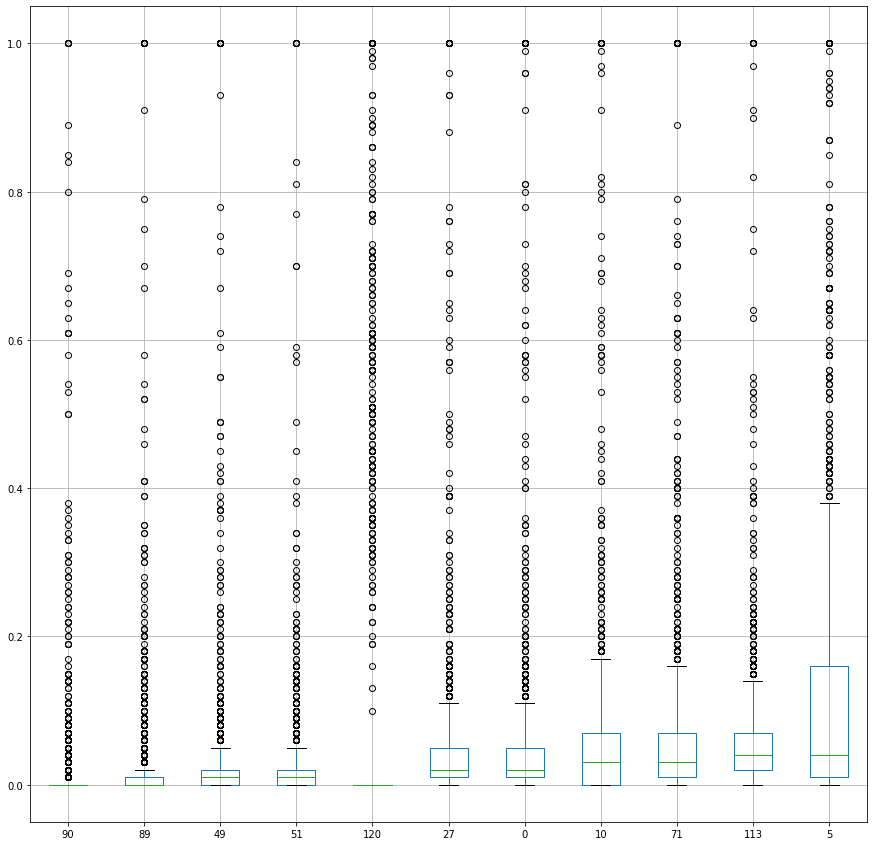

In [52]:
figure = plt.figure(figsize=(15,15))
top_n.iloc[:,0:11].boxplot()

***Comment:*** There seem to be no relationship between the features just by the scatter plot. Thus cannot draw ocnclusion if the features are significant.

# f): Least Square Model 

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
train_x, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]

In [77]:
import statsmodels.api as sm
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
model = sm.OLS(train_y, train_x).fit()
predict = model.predict(test_x)

In [78]:
mse_score = mean_squared_error(test_y, predict)
r_2 = r2_score(test_y, predict)
print("Simple Linear Model: MSE = {:.4F}, R2 = {:.4f}.".format(mse_score, r_2))

Simple Linear Model: MSE = 0.0181, R2 = 0.6185.


# g): Ridge Regression 

In [97]:
from sklearn.linear_model import RidgeCV
train_x, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
model = RidgeCV(cv = 5).fit(train_x, train_y)
predict = model.predict(test_x)
print("The optimal lambda is {}, test MSE = {:.4f}, test R2 = {:.4f}".format(model.alpha_, mean_squared_error(test_y, predict), r2_score(test_y, predict)))

The optimal lambda is 1.0, test MSE = 0.0177, test R2 = 0.6271


# f) Lasso Regression 

In [94]:
# Lasso on raw data 
from sklearn.linear_model import LassoCV
train_x, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
model_raw = LassoCV(cv=5, max_iter = 2000, random_state=1).fit(train_x, train_y)
predict_raw = model_raw.predict(test_x)

In [95]:
# Lasso on standarized data 
from sklearn.preprocessing import StandardScaler
stand = StandardScaler().fit(train_x)
train_x_stand = stand.transform(train_x)
test_x_stand = stand.transform(test_x)

In [96]:
model_stand = LassoCV(cv=5, max_iter = 2000, random_state=1).fit(train_x_stand, train_y)
predict_stand = model_stand.predict(test_x_stand)

In [103]:
print("Raw data: \n"+"optimal lambda = {:.4f}, test MSE = {:.4f}, test R2 = {:.4f}".format(model_raw.alpha_, mean_squared_error(test_y, predict_raw), r2_score(test_y, predict_raw)))
print("Standarized data: \n" +"optimal lambda = {:.4f}, test MSE = {:.4f}, test R2 = {:.4f}".format(model_stand.alpha_, mean_squared_error(test_y, predict_stand), r2_score(test_y, predict_stand)))

Raw data: 
optimal lambda = 0.0001, test MSE = 0.0178, test R2 = 0.6266
Standarized data: 
optimal lambda = 0.0008, test MSE = 0.0178, test R2 = 0.6256


In [113]:
# feature selection 
features_raw = model_raw.coef_!=0
features_stand = model_stand.coef_!=0
print("Raw data:\n"+"Features selected {}".format(train_x.iloc[:,features_raw].columns.values))
print("Standarized data:\n"+"Features selected {}".format(train_x.iloc[:,features_stand].columns.values))

Raw data:
Features selected [  2   4   6   7  11  13  14  15  16  17  18  21  22  23  24  25  26  28
  29  33  34  36  38  39  40  44  45  46  48  49  50  51  55  59  61  63
  64  67  68  69  70  71  72  74  75  76  77  78  79  82  85  86  87  88
  89  90  91  92  94  99 100 102 104 106 108 110 111 112 113 114 115 118
 119 120 121]
Standarized data:
Features selected [  2   4   6   7  11  13  14  15  16  17  18  21  22  23  24  25  26  28
  29  33  34  38  39  40  44  45  46  48  49  50  51  53  55  59  61  63
  64  67  68  69  71  72  74  75  76  77  78  82  85  86  87  88  89  90
  91  94  99 100 102 104 105 106 107 108 110 111 112 113 114 115 116 118
 119]


***Comment:*** Lasso regression proforms similarly on both raw and standardized data. However, it is recommended to standarized data before applying Lasso regression. Another thign that is worth noting is that the "raw" data that we are given has been normalized, thus it lost characteristics of the orignial data because all numbers are squeezed into [0,1] range. Then we applied standarization on the already normalized data. 

# i) PCR model

In [24]:
# standardize train_x and test_x 
train_x, train_y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
test_x, test_y = df_test.iloc[:, :-1], df_test.iloc[:, -1]
stand = StandardScaler().fit(train_x)
train_x, test_x = stand.transform(train_x), stand.transform(test_x)
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)

In [45]:
M = len(train_x.columns.values)

k_fold = KFold(n_splits = 10, shuffle = True, random_state=1)
model = LinearRegression()
mse = []


pca = PCA().fit(train_x)
train_x_reduced = pca.transform(train_x)
train_x_reduced = pd.DataFrame(train_x_reduced)

for m in range(M):
    score = cross_val_score(model, train_x_reduced.loc[:,:m], train_y, scoring = "neg_mean_squared_error",cv=k_fold).mean()*-1
    mse.append(score)


In [70]:
optimal_m = np.argmin(mse)
print("The optimal M = {}".format(optimal_m))
# calculate the test error 
model = LinearRegression().fit(train_x_reduced.loc[:,:optimal_m], train_y)
test_x_reduced = pca.transform(test_x)
test_x_reduced = pd.DataFrame(test_x_reduced)
predict = model.predict(test_x_reduced.loc[:,:optimal_m])
mse = mean_squared_error(test_y, predict)
r2 = r2_score(test_y, predict)
print("The test MSE = {:.4f}, \n R2 = {:.4f}".format(mse, r2))

The optimal M = 0
The test MSE = 0.0281, 
 R2 = 0.4100


# j) XGBoost Tree

In [61]:
alpha_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
mse = []
for alpha in alpha_values:
    model = XGBRegressor(reg_alpha=alpha, objective="reg:squarederror")
    score = cross_val_score(model, train_x, train_y, cv = k_fold, scoring = "neg_mean_squared_error").mean()*-1
    mse.append(score)

In [71]:
optimal_alpha = alpha_values[np.argmin(mse)]
print("The optimal alpha = {}".format(optimal_alpha))
model = XGBRegressor(reg_alpha=optimal_alpha, objective="reg:squarederror").fit(train_x, train_y)
predict = model.predict(test_x)
mse = mean_squared_error(test_y, predict)
r2 = r2_score(test_y, predict)
print("The test error MSE = {:.4f}, \n R2 = {:.4f}".format(mse, r2))

The optimal alpha = 0.0001
The test error MSE = 0.0162, 
 R2 = 0.6590


## References


1.   http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
2.   https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbregressor#xgboost.XGBRegressor

